In [2]:
import pandas as pd

# 读取数据
data = pd.read_csv("data/1_dataset_fillna.csv")
data = data.drop(["M", "Anion", "CC"], axis=1)
data

,O,N,B,S,P,SSA,PV,RMIC,Dap,ID/IG,AML,PW,CD,Cs
0,7.15,3.52,0.00,0.0,0.0,1546.1,0.5753,0.939857,1.488390,1.029,1.00,1.6,0.10,85.0
1,8.12,3.79,3.66,0.0,0.0,1315.2,0.5116,0.931392,1.555961,1.038,1.00,1.6,0.10,114.0
2,21.55,3.29,0.00,0.0,0.0,1140.8,0.8600,0.209302,3.015428,0.820,2.50,1.8,0.10,90.2
3,21.55,3.29,0.00,0.0,0.0,1140.8,0.8600,0.209302,3.015428,0.820,2.50,1.8,0.25,86.3
4,21.55,3.29,0.00,0.0,0.0,1140.8,0.8600,0.209302,3.015428,0.820,2.50,1.8,0.50,79.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,4.68,5.02,0.00,0.0,0.0,166.6,0.1380,0.289855,3.313325,0.830,2.75,1.6,10.00,67.1
668,4.68,5.02,0.00,0.0,0.0,166.6,0.1380,0.289855,3.313325,0.830,2.75,1.6,20.00,63.1
669,4.68,5.02,0.00,0.0,0.0,166.6,0.1380,0.289855,3.313325,0.830,2.75,1.6,30.00,59.6
670,4.68,5.02,0.00,0.0,0.0,166.6,0.1380,0.289855,3.313325,0.830,2.75,1.6,40.00,59.3


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 按目标值分布按10个等级进行数据分割
data['target_class'] = pd.qcut(data['Cs'], q=10, labels=False)
X = data.drop('Cs', axis=1)
y = data['Cs']
stratify_column = data['target_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=stratify_column)

# 数据标准化
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 将数据转换成DF以便后续使用
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

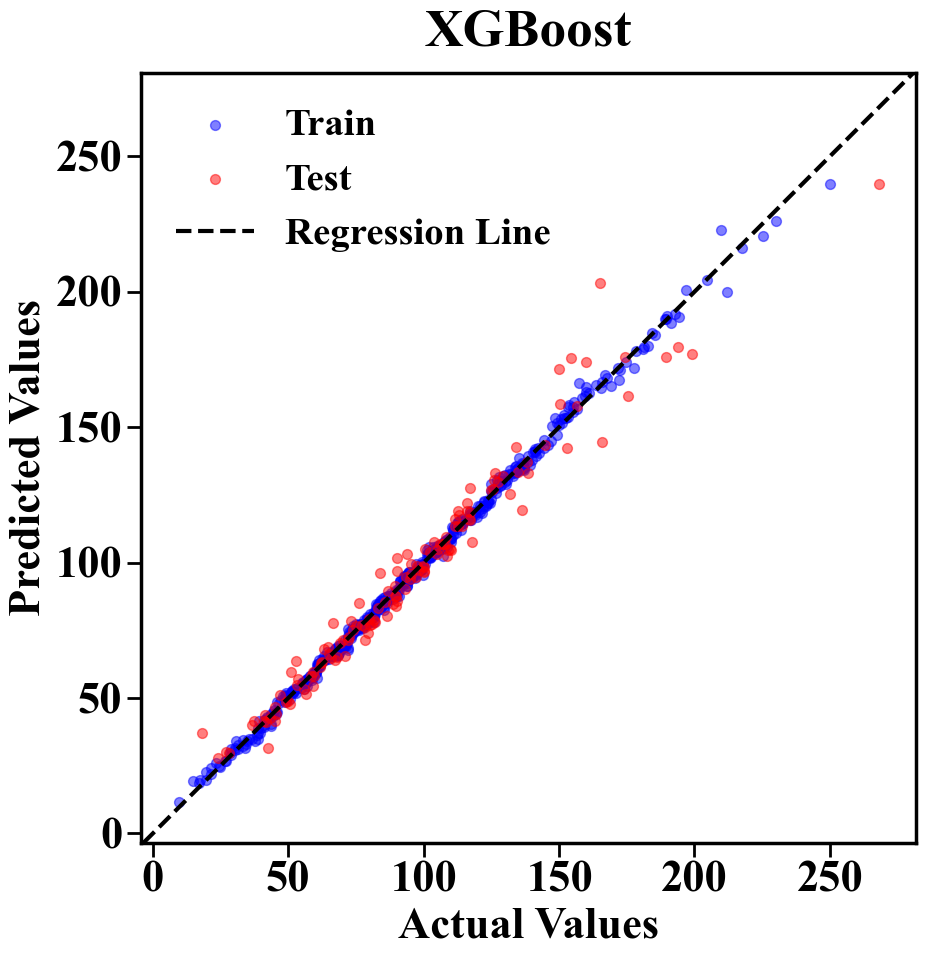

,model,R2_train,MAE_train,MAPE_train,RMSE_train,R2_test,MAE_test,MAPE_test,RMSE_test
0,XGBoost,0.997777,1.302453,1.670627,1.872018,0.963171,4.89165,5.710019,7.699226


In [7]:
from function import metrics_to_dataframe, plot_actual_vs_predicted
from xgboost import XGBRegressor

# 初始化模型
xgb = XGBRegressor(n_estimators=100,
                   learning_rate=0.15,
                   subsample=0.5,
                   gamma=0.1,
                   max_depth=8,
                   min_child_weight=2,
                   reg_alpha=0.35,
                   colsample_bytree=0.7,
                   colsample_bylevel=1.0,
                   colsample_bynode=0.7,
                   random_state=21)
xgb.fit(X_train_scaled, y_train)

y_train_pred = xgb.predict(X_train_scaled)
y_test_pred = xgb.predict(X_test_scaled)

xgb_metrics = metrics_to_dataframe(y_train, y_train_pred, y_test, y_test_pred, 'XGBoost')
plot_actual_vs_predicted(y_train, y_train_pred, y_test, y_test_pred, 'XGBoost','output/figures/XGB.png')

xgb_metrics